In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from tensorflow.keras import layers, Input, optimizers, losses, activations, models, applications
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate, BatchNormalization, GlobalAveragePooling2D, Activation

In [2]:
TARGET_SIZE = 256
train_datagen = ImageDataGenerator(rescale=1./255.,
                                     featurewise_center=True,
                                     validation_split = 0.08,
                                   zoom_range = 0.07
                                    )
test_datagen = ImageDataGenerator(rescale= 1./255)
train_data = train_datagen.flow_from_directory(
    '../input/covidradiography2/COVID-19 Radiography Database/Train',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE,TARGET_SIZE),
    shuffle=True,
    subset="training",
)

validation_data = train_datagen.flow_from_directory(
    '../input/covidradiography2/COVID-19 Radiography Database/Train',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=True,
    subset="validation",
)

test_data = test_datagen.flow_from_directory(
    '../input/covidradiography2/COVID-19 Radiography Database/Test',
    class_mode="sparse",
    batch_size=32,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=False,
)

Found 3290 images belonging to 3 classes.
Found 284 images belonging to 3 classes.
Found 312 images belonging to 3 classes.


In [3]:
base_model = tf.keras.applications.DenseNet169(weights="imagenet",include_top=False,input_shape=(TARGET_SIZE,TARGET_SIZE, 3))
y1 = base_model.output
y = GlobalAveragePooling2D()(y1)
x = Dense(512, activation='relu')(y)
x=Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

for layer in base_model.layers[:369]:
    layer.trainable = False
for layer in base_model.layers[369:]:
    layer.trainable = True

model=Sequential()
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.1),metrics=['accuracy'])
model.summary()
model_save = ModelCheckpoint('weights.h5', 
                              save_best_only = True, 
                              save_weights_only = True,
                              monitor = 'val_loss', 
                              mode = 'min', verbose = 1)


51879936/51877672 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________

In [4]:
EPOCHS = 10
history = model.fit_generator(
     train_data,
     steps_per_epoch=train_data.samples//train_data.batch_size,
     epochs = EPOCHS,
     validation_data = validation_data,
     validation_steps=validation_data.samples//validation_data.batch_size,
     callbacks = [model_save])

Epoch 1/10
102/102 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.9067
Epoch 00001: val_loss improved from inf to 0.18882, saving model to weights.h5
102/102 [==============================] - 174s 2s/step - loss: 0.2834 - accuracy: 0.9067 - val_loss: 0.1888 - val_accuracy: 0.9258
Epoch 2/10
102/102 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.9543
Epoch 00002: val_loss improved from 0.18882 to 0.07443, saving model to weights.h5
102/102 [==============================] - 119s 1s/step - loss: 0.1284 - accuracy: 0.9543 - val_loss: 0.0744 - val_accuracy: 0.9805
Epoch 3/10
102/102 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9785
Epoch 00003: val_loss improved from 0.07443 to 0.03955, saving model to weights.h5
102/102 [==============================] - 119s 1s/step - loss: 0.0718 - accuracy: 0.9785 - val_loss: 0.0396 - val_accuracy: 0.9844
Epoch 4/10
102/102 [==============================] - ETA: 0s - loss: 0

In [5]:
pred = model.predict_generator(test_data)
y_pred = pred.argmax(axis=-1)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [6]:
model.evaluate(test_data)

10/10 [==============================] - 5s 464ms/step - loss: 0.0249 - accuracy: 0.9968


[0.02493244595825672, 0.9967948794364929]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


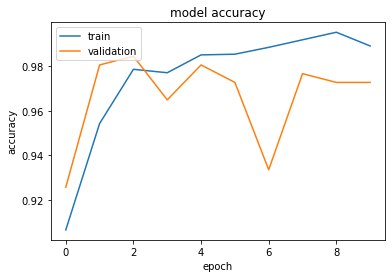

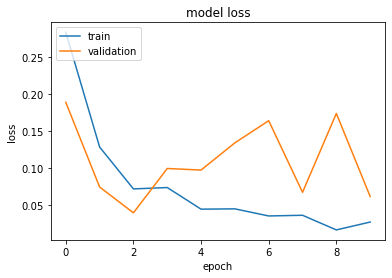

In [7]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Confusion Matrix
[[104   0   0]
 [  0 104   0]
 [  0   1 103]]
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       104
           1    0.99048   1.00000   0.99522       104
           2    1.00000   0.99038   0.99517       104

    accuracy                        0.99679       312
   macro avg    0.99683   0.99679   0.99679       312
weighted avg    0.99683   0.99679   0.99679       312



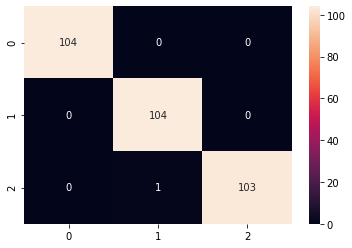

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)
print(sns.heatmap(confusion_matrix(test_data.classes, y_pred),annot=True, fmt= "d"))
print(classification_report(test_data.classes, y_pred, digits=5))

In [9]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print(np.mean(recall))
print(np.mean(precision))

0.9967948717948718
0.9968253968253968
